In [3]:
from __future__ import print_function

import tensorflow as tf

import os
import sys
import numpy as np
import pickle5 as pickle
import tempfile

import keras
from keras.preprocessing.text import Tokenizer
import keras.backend as K
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Input, Embedding, Activation, Softmax
from keras.layers import CuDNNLSTM
from keras.models import Model, Sequential
from keras.layers import Conv1D,Conv2D, ZeroPadding2D, MaxPooling1D, MaxPooling2D
from keras.layers import RepeatVector, Permute, Add, Concatenate, Reshape, Dot
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph, IndexedArray
from gensim.models import Word2Vec
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
from graph_visualization import GraphVisualization

np.random.seed(100)

MAX_NUM_WORDS = 20000
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.2

NUM_RELATIONS_PER_CLUSTER = 67
NUM_ENTITIES_PER_CLUSTER = 400
NUM_CLUSTERS = 20

def get_clusters(cluster_file, num_things_per_cluster):
    clusters = []  # np.ones(shape=(NUM_RELATIONS_PER_CLUSTER,KG_EMBEDDING_DIM))

    with open(cluster_file, 'r', encoding='utf8') as f:
        lines = []
        for line in f:
            elements = line.split()
            x = [[e] for e in elements]
            lines.append(x)

    for i in range(0, len(lines) - num_things_per_cluster + 1, num_things_per_cluster):
        # print("appending: {} to {}".format(i,i+num_things_per_cluster))
        clusters.append(lines[i:i + num_things_per_cluster])

    clusters = np.asarray(clusters, dtype='float32')
    return clusters


def pickler(path, pkl_name, obj):
    with open(os.path.join(path, pkl_name), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def unpickler(path, pkl_name):
    with open(os.path.join(path, pkl_name), 'rb') as f:
        obj = pickle.load(f)
    return obj

def get_labels(data):
    labels = []
    for d in data:
        labels.append(d['label']) if d['label'] not in labels else None

    return labels


def get_x_and_y(data):
    x, y = [], []
    for d in data:
        for dd in d['data']:
            tmp = dd['text'].replace('\n', '').replace('_', '')  # clean
            x.append({'label': d['label'], 'dbpedia_uri': dd['dbpedia_uri'], 'context_data': dd['context_data'], 'text': tmp, 'graph': dd['graph']}) if len(tmp) > 0 else None
            y.append(d['label']) if len(tmp) > 0 else None

    return x, y


def get_label_index(label):
    return [index for index, _label in enumerate(unique_labels) if label == _label][0]


### LOAD DATA

In [4]:
def find_clusters(arr):    
    result = []
    for el in arr:
        all_mappings = node_cluster_mapping_with_count[el] if el in node_cluster_mapping_with_count else []
        filtered_mappings = [e[0] for e in all_mappings[:min(len(all_mappings),3)]]
        result.extend(filtered_mappings)
    
    return result

def get_context_data(data):
    for d in data:
        for dd in d['data']:
            dd['context_data'] = [c for c in set(find_clusters(dd['context_graph']['nodes']))]

In [5]:
node_embeddings_v3 = unpickler('data','node_embeddings_v3.pkl')
node_embeddings_v4 = unpickler('data','node_embeddings_v4.pkl')
graph = unpickler('data','graph_v3.pkl')
clusters = unpickler('data','node_clusters_v5.pkl')
clusters_with_count = unpickler('data','node_clusters_v5_with_count.pkl')
node_cluster_mapping_with_count= unpickler('data','node_cluster_mapping_v5_with_count.pkl')

In [6]:
data = unpickler('data','classification_data_with_graphs_v5.pkl')

unique_labels = get_labels(data)

get_context_data(data)

x,y = get_x_and_y(data)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
x_val, y_val,x_test, y_test = x_test[:500], y_test[:500], x_test[500:], y_test[500:]
y_train_int, y_test_int = [get_label_index(label) for label in y_train],[get_label_index(label) for label in y_test]
x_train_text,x_val_text,x_test_text = [xx['text'] for xx in x_train],[xx['text'] for xx in x_val], [xx['text'] for xx in x_test]
x_train_context, x_val_context, x_test_context = [xx['context_data'] for xx in x_train],[xx['context_data'] for xx in x_val], [xx['context_data'] for xx in x_test]

### SIMPLE DNN

In [6]:
max_features = 10000
sequence_length = 200

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

with tf.device("/CPU:0"):
    vectorize_layer.adapt(x_train_text)

In [21]:
MAX_TOKENS_NUM = 5000  # Maximum vocab size.
EMBEDDING_DIMS = 100

text_input = tf.keras.Input(shape=(1,), dtype=tf.string)

text_layer = vectorize_layer(text_input)
text_layer = tf.keras.layers.Embedding(MAX_TOKENS_NUM + 1, EMBEDDING_DIMS)(text_layer)
text_layer = tf.keras.layers.GlobalAveragePooling1D()(text_layer)

final_output = tf.keras.layers.Dense(units=len(unique_labels))(text_layer)

model_simple = tf.keras.models.Model(inputs=[text_input], outputs=final_output)
model_simple.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.SparseCategoricalAccuracy())

In [25]:
epochs =  50
history = model_simple.fit(
    x_train_text,
    y=y_train_int,
    epochs=epochs)

Epoch 1/50
141/141 [==============================] - 2s 11ms/step - loss: 0.7540 - sparse_categorical_accuracy: 0.8544
Epoch 2/50
141/141 [==============================] - 2s 11ms/step - loss: 0.7192 - sparse_categorical_accuracy: 0.8606
Epoch 3/50
141/141 [==============================] - 2s 11ms/step - loss: 0.6866 - sparse_categorical_accuracy: 0.8655
Epoch 4/50
141/141 [==============================] - 2s 11ms/step - loss: 0.6556 - sparse_categorical_accuracy: 0.8715
Epoch 5/50
141/141 [==============================] - 2s 11ms/step - loss: 0.6265 - sparse_categorical_accuracy: 0.8802
Epoch 6/50
141/141 [==============================] - 2s 11ms/step - loss: 0.5991 - sparse_categorical_accuracy: 0.8833
Epoch 7/50
141/141 [==============================] - 2s 11ms/step - loss: 0.5729 - sparse_categorical_accuracy: 0.8900
Epoch 8/50
141/141 [==============================] - 2s 12ms/step - loss: 0.5481 - sparse_categorical_accuracy: 0.8942
Epoch 9/50
141/141 [====================

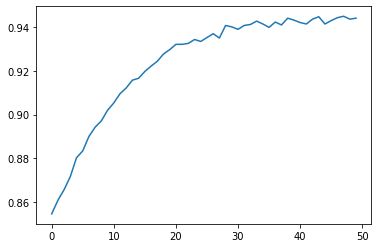

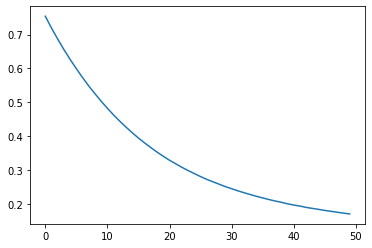

In [26]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.show()
plt.plot(history.history['loss'])
plt.show()

In [27]:
results = model_simple.predict(x_test_text)
def get_result_labels(results):
    return [unique_labels[np.where(row==max(row))[0][0]] for row in results]

result_labels = get_result_labels(results)
print('Accuracy score: %.2f' % accuracy_score(result_labels, y_test))
print(classification_report(y_test, result_labels))


Accuracy score: 0.66
                              precision    recall  f1-score   support

                Architecture       0.92      0.89      0.91        27
      Architecture-Structure       0.87      0.68      0.76        19
                  Art-Cinema       0.70      0.76      0.73        25
            Art-Cinema-Actor       0.24      0.19      0.21        26
                   Art-Dance       0.83      0.83      0.83        18
            Art-Dance-Dancer       0.58      0.56      0.57        25
                 Art-Fashion       0.67      0.69      0.68        26
        Art-Fashion-Designer       0.67      0.57      0.62        28
           Art-Fashion-Model       1.00      0.40      0.57        10
              Art-Literature       0.61      0.74      0.67        27
       Art-Literature-Writer       0.48      0.62      0.55        24
                   Art-Music       0.89      0.83      0.86        30
        Art-Music-Instrument       1.00      0.75      0.86        2

### DNN WITH CONTEXT

In [70]:
max_features = 10000
sequence_length = 200

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

with tf.device("/CPU:0"):
    vectorize_layer.adapt(x_train_text)

In [71]:
MAX_TOKENS_NUM = 5000  # Maximum vocab size.
EMBEDDING_DIMS = 100

cluster_names = unique_labels + ['None']

text_input = tf.keras.Input(shape=(1,), dtype=tf.string)

text_layer = vectorize_layer(text_input)
text_layer = tf.keras.layers.Embedding(MAX_TOKENS_NUM + 1, EMBEDDING_DIMS)(text_layer)
text_layer = tf.keras.layers.GlobalAveragePooling1D()(text_layer)

context_input = Input(shape=(1,), dtype='string', name='graph_input')                           
context_layer = tf.keras.layers.StringLookup(vocabulary=cluster_names, output_mode='multi_hot')(context_input)

concatenated = Concatenate(axis=1)([text_layer, context_layer])
final_output = Dense(units=len(unique_labels), activation='softmax')(concatenated)

model_2 = tf.keras.models.Model(inputs=[text_input, context_input], outputs=final_output)
model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.SparseCategoricalAccuracy())

In [72]:
x_train_input = pd.DataFrame(x_train_text).values
context_data_train_input = pd.DataFrame(x_train_context).values
y_train_output = pd.DataFrame(y_train_int).values

for c in context_data_train_input:
    for i,v in enumerate(c):
        c[i] = 'Other' if not v else v 

epochs =  50
history = model_2.fit(
    [x_train_input,context_data_train_input],
    y=y_train_output,
    epochs=epochs)

Epoch 1/50


/home/cnytync/Dev/anaconda3/envs/Python36/lib/python3.6/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


141/141 [==============================] - 2s 12ms/step - loss: 4.1518 - sparse_categorical_accuracy: 0.0965
Epoch 2/50
141/141 [==============================] - 2s 12ms/step - loss: 3.6568 - sparse_categorical_accuracy: 0.3063
Epoch 3/50
141/141 [==============================] - 2s 12ms/step - loss: 3.2426 - sparse_categorical_accuracy: 0.4250
Epoch 4/50
141/141 [==============================] - 2s 11ms/step - loss: 2.8889 - sparse_categorical_accuracy: 0.5072
Epoch 5/50
141/141 [==============================] - 2s 12ms/step - loss: 2.5721 - sparse_categorical_accuracy: 0.5688
Epoch 6/50
141/141 [==============================] - 2s 11ms/step - loss: 2.2956 - sparse_categorical_accuracy: 0.6119
Epoch 7/50
141/141 [==============================] - 2s 12ms/step - loss: 2.0579 - sparse_categorical_accuracy: 0.6459
Epoch 8/50
141/141 [==============================] - 2s 12ms/step - loss: 1.8533 - sparse_categorical_accuracy: 0.6753
Epoch 9/50
141/141 [==============================]

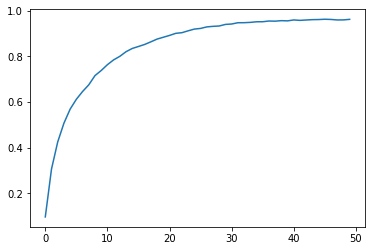

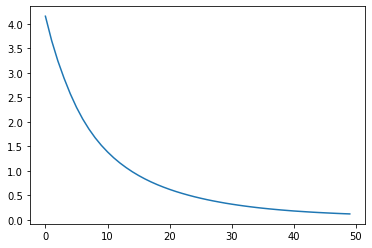

In [73]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.show()
plt.plot(history.history['loss'])
plt.show()

In [74]:
# Restore the best found model during validation
# m.load_weights(tmpfn)

x_test_input = pd.DataFrame(x_test_text).values
context_data_test_input = pd.DataFrame(x_test_context).values
y_test_output = pd.DataFrame(y_test_int).values

for c in context_data_test_input:
    for i,v in enumerate(c):
        c[i] = 'Other' if not v else v 
        
loss, acc = model_2.evaluate([x_test_input,context_data_test_input], y_test_output)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))

54/54 [==============================] - 1s 10ms/step - loss: 0.8268 - sparse_categorical_accuracy: 0.7437
Test loss / test accuracy = 0.8268 / 0.7437


In [76]:
results = model_2.predict([x_test_input,context_data_test_input])
def get_result_labels(results):
    return [unique_labels[np.where(row==max(row))[0][0]] for row in results]

result_labels = get_result_labels(results)
print('Accuracy score: %.2f' % accuracy_score(result_labels, y_test))
print(classification_report(y_test, result_labels))

Accuracy score: 0.74
                              precision    recall  f1-score   support

                Architecture       0.93      0.93      0.93        27
      Architecture-Structure       0.86      0.95      0.90        19
                  Art-Cinema       0.71      0.88      0.79        25
            Art-Cinema-Actor       0.27      0.23      0.25        26
                   Art-Dance       1.00      1.00      1.00        18
            Art-Dance-Dancer       0.87      0.80      0.83        25
                 Art-Fashion       0.79      0.88      0.84        26
        Art-Fashion-Designer       0.79      0.68      0.73        28
           Art-Fashion-Model       0.86      0.60      0.71        10
              Art-Literature       0.83      0.89      0.86        27
       Art-Literature-Writer       0.72      0.88      0.79        24
                   Art-Music       0.97      0.97      0.97        30
        Art-Music-Instrument       0.87      0.83      0.85        2

### DNN WITH CONTEXT/NODE EMBEDDINGS

#### Group Node Embeddings

In [7]:
def group_embeddings(node_embeddings,graph):
    i, groups = 0, [[] for i in range(len(unique_labels))]
    for node, embedding in zip(graph['nodes'],node_embeddings):
        print('%.2f%%' % ((i * 100) / len(graph['nodes']))) if i % 5000 == 0 else None
        i += 1
        
        node_categories = [m[0] for m in node_cluster_mapping_v3_with_count[node]] if node in node_cluster_mapping_with_count else []
        category_indexes = [unique_labels.index(c) for c in node_categories]
        
        for i2, group in enumerate(groups):
            group.append(embedding) if i2 in category_indexes else None # [[v] for v in embedding]
        
    # pickler('data','embedding_groups_v2.pkl', groups)
    
    # max_length = 0
    # for group in groups:
    #     max_length = max(max_length, len(group))
    
#     max_length = 1280
#     for group in groups:
#         for i in range(len(group),max_length):
#             group.append([0 for i2 in range(100)])
    
#     new_groups = []
#     for group in groups:
#         new_groups.append(group[:(max_length)])
    
    return groups
    
embedding_groups = group_embeddings(node_embeddings_v4,graph_v2)

0.00%
21.64%
43.28%
64.92%
86.56%


#### Analyze Embedding Groups

In [8]:
import random
from numpy.linalg import norm

def cosine_sim(A,B):
    return np.dot(A,B)/(norm(A)*norm(B))

def group_similarity(i):
    group = embedding_groups[i]

    sims, c = 0, 0
    for i1, embedding1 in enumerate(group):
        for i2 in range(i1,len(group)):
            embedding2 = group[i2]
            sims += cosine_sim(embedding1, embedding2)
            c += 1

    return sims / c

def inter_group_similarity(i1,i2):
    group1 = embedding_groups[i1]
    group2 = embedding_groups[i2]

    sims, c = 0, 0
    for j1, embedding1 in enumerate(group1):
        for j2, embedding2 in enumerate(group2):
            sims += cosine_sim(embedding1, embedding2)
            c += 1

    return sims / c

group_similarity(1), inter_group_similarity(0,1)

(0.33404458906000745, 0.33628847711591975)

In [156]:
i1,i2 = 0,1
emb1, emb2 = node_embeddings_v4[i1],node_embeddings_v4[i2]
n1,n2 = graph_v2['nodes'][i1], graph_v2['nodes'][i2]

n1, n2, cosine_sim(emb1,emb2)

('The Vision of Saint Eustace', 'Artwork', 0.26538447)

In [54]:
graph_embedding_size = 100
from numpy.linalg import norm

def cosine_sim(A,B):
    return np.dot(A,B)/(norm(A)*norm(B))

def get_embedding(graph):
    edges_ = pd.DataFrame({
            'source': [e['source'] for e in graph['edges']],
            'target': [e['target'] for e in graph['edges']],
            'type': graph['edge_types']
        })

    G = StellarGraph(IndexedArray(index=graph['nodes']), edges_, edge_type_column="type")

    walk_length = 10
    rw = BiasedRandomWalk(G)
    walks = rw.run(
        nodes=G.nodes(),  # root nodes
        length=walk_length,  # maximum length of a random walk
        n=5,  # number of random walks per root node
        p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
        q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
        weighted=False,  # for weighted random walks
        seed=42,  # random seed fixed for reproducibility
    )

    model = Word2Vec(
        walks,  vector_size=graph_embedding_size, window=2, min_count=1, sg=1, workers=1
    )

    return model.wv.vectors

graph_ex = {'nodes': [0,1,2,3,4,5,6,7,8,9,10], 
            'edges': [
                { 'source': 0,'target': 1},
                {'source': 0,'target': 2},
                {'source': 0,'target': 3},
                {'source': 1,'target': 2},
                {'source': 1,'target': 3},
                {'source': 2,'target': 3},
                {'source': 2,'target': 4},
                {'source': 4,'target': 5},
                {'source': 4,'target': 6},
                {'source': 5,'target': 6},
                {'source': 6,'target': 7},
                {'source': 5,'target': 8},
                {'source': 5,'target': 9},
                {'source': 9,'target': 10}
            ], 'edge_types': [1,1,1,1,1,1,1,1,1,1,1,1,1,1]}

G = GraphVisualization()

for edge in graph_ex['edges'][:100]:
    G.addEdge(edge['source'],edge['target'])
# G.visualize()

embeddings_ex = get_embedding(graph_ex)

In [55]:
A = embeddings_ex[0]
B = embeddings_ex[1]
C = embeddings_ex[10]
cosine_sim(A,B),cosine_sim(A,C),cosine_sim(B,C)

(0.018792106, 0.08034596, -0.09701292)

In [60]:
G = GraphVisualization()

%matplotlib qt
for edge in graph_v2['edges'][:100]:
    G.addEdge(edge['source'],edge['target'])
G.visualize()

In [103]:
context_input = Input(shape=(1,), dtype='string', name='graph_input')                           
context_layer = tf.keras.layers.StringLookup(vocabulary=cluster_names, output_mode='multi_hot')(context_input)
# context_layer = Sum(context_layer)
# context_layer = keras.layers.core.Lambda(lambda x: tf.expand_dims(x,axis=1))(context_layer)
print("context_layer", K.int_shape(context_layer))

# get representation for entity clusters
# embedding_groups_input = Input(tensor=embedding_groups_tensor,name='embedding_groups_input')
embedding_groups_input = FakeEmbeddingGroupsInput(context_layer)
l = Conv1D(filters=1, kernel_size=2, strides=2)(embedding_groups_input)
l = MaxPooling1D(pool_size=2, strides=2)(l)
l = Conv1D(filters=1, kernel_size=2, strides=2)(l)
l = MaxPooling1D(pool_size=2, strides=2)(l)
l = RemoveLastCol(l)
print("embedding_clusters_layer", K.int_shape(l))
# embedding_clusters_layer = Reshape([80], name='entity_cluster_reps')(l)
embedding_clusters_layer = l

#attention over entities
att_scores = DotProduct([embedding_clusters_layer, Transpose(context_layer)])
print("att_scores", K.int_shape(att_scores))
att_normalized = Softmax(axis=-1, name='entity_attention')(att_scores)
print("att_normalized", K.int_shape(att_normalized))
embedding_attention_result_layer = DotProduct([Transpose(embedding_clusters_layer), att_normalized])
print("embedding_attention_result_layer", K.int_shape(embedding_attention_result_layer))

model_3 = tf.keras.models.Model(inputs=[context_input], outputs=embedding_attention_result_layer)

res = model_3.predict([['Art-Painting','Science-Biology'],['Art-Sculpting','Science-Chemistry']])
res.shape,res

context_layer (None, 80)
embedding_clusters_layer (78, 80)
att_scores (78, None)
att_normalized (78, None)
embedding_attention_result_layer (80, None)


#### Prepare Neural Net

In [7]:
max_features = 10000
sequence_length = 200

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

with tf.device("/CPU:0"):
    vectorize_layer.adapt(x_train_text)

In [106]:
MAX_TOKENS_NUM = 5000  # Maximum vocab size.
EMBEDDING_DIMS = 100

Avg = keras.layers.core.Lambda(lambda x: K.mean(x, axis=1))  # , output_shape=(KG_EMBEDDING_DIM, ))
DotProduct = keras.layers.core.Lambda(lambda x: K.dot(x[0], x[1]))  # , output_shape=(KG_EMBEDDING_DIM, ))
Sum = keras.layers.core.Lambda(lambda x: K.sum(x, axis=0))  # , output_shape=(KG_EMBEDDING_DIM, ))
RemoveLastCol = keras.layers.core.Lambda(lambda x: K.sum(x, axis=-1))
Transpose = keras.layers.core.Lambda(lambda x: K.transpose(x))
FakeEmbeddingGroupsInput = keras.layers.core.Lambda(lambda x: np.asarray(embedding_groups), dtype='float32')
# np.expand_dims(pd.DataFrame(embedding_groups).values,axis=2)
# embedding_groups_tensor = K.variable(embedding_groups)

cluster_names = unique_labels + ['None']

# embedding_groups_input = pd.DataFrame([[0,1,2] for i in range(len(embedding_groups))]).values

text_input = tf.keras.Input(shape=(1,), dtype=tf.string)

text_layer = vectorize_layer(text_input)
text_layer = tf.keras.layers.Embedding(MAX_TOKENS_NUM + 1, EMBEDDING_DIMS)(text_layer)
text_layer = tf.keras.layers.GlobalAveragePooling1D()(text_layer)
print("text_layer", K.int_shape(text_layer))

context_input = Input(shape=(1,), dtype='string', name='graph_input')                           
context_layer = tf.keras.layers.StringLookup(vocabulary=cluster_names, output_mode='multi_hot')(context_input)
# context_layer = Sum(context_layer)
# context_layer = keras.layers.core.Lambda(lambda x: tf.expand_dims(x,axis=1))(context_layer)
print("context_layer", K.int_shape(context_layer))

# get representation for entity clusters
# embedding_groups_input = Input(tensor=embedding_groups_tensor,name='embedding_groups_input')
embedding_groups_input = FakeEmbeddingGroupsInput(context_layer)
l = Conv1D(filters=1, kernel_size=2, strides=2)(embedding_groups_input)
l = MaxPooling1D(pool_size=2, strides=2)(l)
l = Conv1D(filters=1, kernel_size=2, strides=2)(l)
l = MaxPooling1D(pool_size=2, strides=2)(l)
l = RemoveLastCol(l)
print("embedding_clusters_layer", K.int_shape(l))
# embedding_clusters_layer = Reshape([80], name='entity_cluster_reps')(l)
embedding_clusters_layer = l

#attention over entities
att_scores = DotProduct([embedding_clusters_layer, Transpose(context_layer)])
print("att_scores", K.int_shape(att_scores))
att_normalized = Softmax(axis=-1, name='entity_attention')(att_scores)
print("att_normalized", K.int_shape(att_normalized))
embedding_attention_result_layer = DotProduct([Transpose(embedding_clusters_layer), att_normalized])
print("embedding_attention_result_layer", K.int_shape(embedding_attention_result_layer))

concatenated = Concatenate(axis=0)([Transpose(text_layer), embedding_attention_result_layer])
print("concatenated", K.int_shape(concatenated))
final_output = Dense(units=len(unique_labels), activation='softmax')(Transpose(concatenated))

model_3 = tf.keras.models.Model(inputs=[text_input, context_input], outputs=final_output)
model_3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.SparseCategoricalAccuracy())

model_3.summary()

text_layer (None, 100)
context_layer (None, 80)
embedding_clusters_layer (78, 80)
att_scores (78, None)
att_normalized (78, None)
embedding_attention_result_layer (80, None)
concatenated (180, None)
Model: "model_49"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
graph_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
string_lookup_56 (StringLookup) (None, 80)           0           graph_input[0][0]                
__________________________________________________________________________________________________
lambda_181 (Lambda)             (78, 1280, 100)      0           string_lookup_56[0][0]           
__________________________________________________________________________________________

In [107]:
x_train_input = pd.DataFrame(x_train_text).values
context_data_train_input = pd.DataFrame(x_train_context).values
y_train_output = pd.DataFrame(y_train_int).values

print('Input shapes',x_train_input.shape,context_data_train_input.shape,y_train_output.shape)
for c in context_data_train_input:
    for i,v in enumerate(c):
        c[i] = 'Other' if not v else v 

epochs =  20
history = model_3.fit(
    [x_train_input,context_data_train_input],
    y=y_train_output, batch_size=1,
    epochs=epochs)

Input shapes (4499, 1) (4499, 38) (4499, 1)
Epoch 1/20


/home/cnytync/Dev/anaconda3/envs/Python36/lib/python3.6/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


4499/4499 [==============================] - 25s 5ms/step - loss: 4.4775 - sparse_categorical_accuracy: 0.0662
Epoch 2/20
4499/4499 [==============================] - 22s 5ms/step - loss: 3.0090 - sparse_categorical_accuracy: 0.2834
Epoch 3/20
4499/4499 [==============================] - 22s 5ms/step - loss: 2.1407 - sparse_categorical_accuracy: 0.4928
Epoch 4/20
4499/4499 [==============================] - 22s 5ms/step - loss: 1.5731 - sparse_categorical_accuracy: 0.6241
Epoch 5/20
4499/4499 [==============================] - 22s 5ms/step - loss: 1.2079 - sparse_categorical_accuracy: 0.7097
Epoch 6/20
4499/4499 [==============================] - 22s 5ms/step - loss: 0.9568 - sparse_categorical_accuracy: 0.7671
Epoch 7/20
4499/4499 [==============================] - 22s 5ms/step - loss: 0.7697 - sparse_categorical_accuracy: 0.8115
Epoch 8/20
4499/4499 [==============================] - 22s 5ms/step - loss: 0.6196 - sparse_categorical_accuracy: 0.8446
Epoch 9/20
4499/4499 [=============

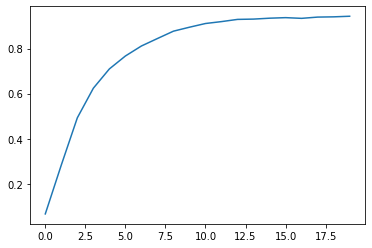

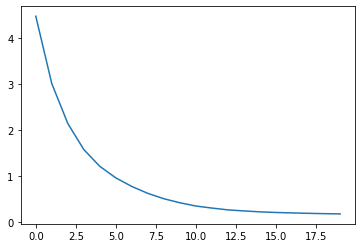

In [108]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.show()
plt.plot(history.history['loss'])
plt.show()

In [110]:
# Restore the best found model during validation
# m.load_weights(tmpfn)

x_test_input = pd.DataFrame(x_test_text).values
context_data_test_input = pd.DataFrame(x_test_context).values
y_test_output = pd.DataFrame(y_test_int).values

for c in context_data_test_input:
    for i,v in enumerate(c):
        c[i] = 'Other' if not v else v 
        
new_context_data_test_input = pd.DataFrame(new_context_data_test_input).values
        
loss, acc = model_3.evaluate([x_test_input,context_data_test_input], y_test_output)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))

54/54 [==============================] - 3s 10ms/step - loss: 1.3994 - sparse_categorical_accuracy: 0.6564
Test loss / test accuracy = 1.3994 / 0.6564


In [111]:
results = model_3.predict([x_test_input,new_context_data_test_input], batch_size=1)
def get_result_labels(results):
    return [unique_labels[np.where(row==max(row))[0][0]] for row in results]

result_labels = get_result_labels(results)
print('Accuracy score: %.2f' % accuracy_score(result_labels, y_test))
print(classification_report(y_test, result_labels))

Accuracy score: 0.66
                              precision    recall  f1-score   support

                Architecture       1.00      0.89      0.94        27
      Architecture-Structure       0.87      0.68      0.76        19
                  Art-Cinema       0.66      0.76      0.70        25
            Art-Cinema-Actor       0.20      0.12      0.15        26
                   Art-Dance       0.86      0.67      0.75        18
            Art-Dance-Dancer       0.70      0.64      0.67        25
                 Art-Fashion       0.72      0.69      0.71        26
        Art-Fashion-Designer       0.70      0.57      0.63        28
           Art-Fashion-Model       1.00      0.50      0.67        10
              Art-Literature       0.62      0.74      0.68        27
       Art-Literature-Writer       0.52      0.62      0.57        24
                   Art-Music       0.82      0.77      0.79        30
        Art-Music-Instrument       0.94      0.67      0.78        2

/home/cnytync/Dev/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cnytync/Dev/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cnytync/Dev/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

### SVM WITH CONTEXT

In [7]:
import sys

sys.path.append('../')

import bz2
import csv, logging, pickle5 as pickle, pandas as pd, re, random
from dewiki.parser import Parser

from wikitextprocessor import Wtp
import seaborn as sns

import requests
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

import requests, os


def pickler(path, pkl_name, obj):
    with open(os.path.join(path, pkl_name), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def unpickler(path, pkl_name):
    with open(os.path.join(path, pkl_name), 'rb') as f:
        obj = pickle.load(f)
    return obj


In [8]:
node_cluster_mapping_with_count['Mona Lisa']

[('Art-Painting', 100), ('Art-Music-Instrument', 2), ('Nature-Plant', 2), ('Nature-Food', 1), ('Nature-Microorganism', 1), ('Culture-Country', 1)]

In [9]:
cluster_names = unique_labels + ['None']

context_input = Input(shape=(1,), dtype='string', name='graph_input')                           
context_layer = tf.keras.layers.StringLookup(vocabulary=cluster_names, output_mode='multi_hot')(context_input)

m = tf.keras.models.Model(inputs=[context_input], outputs=context_layer)

context_data_train_input = pd.DataFrame(x_train_context).values

for c in context_data_train_input:
    for i, v in enumerate(c):
        c[i] = 'Other' if not v else v

context_train_encodings = m.predict(context_data_train_input)

for encoding in context_train_encodings:
    encoding[78] = 0.0
    
context_data_test_input = pd.DataFrame(x_test_context).values

for c in context_data_test_input:
    for i,v in enumerate(c):
        c[i] = 'Other' if not v else v 

context_test_encodings = m.predict(context_data_test_input)

for encoding in context_test_encodings:
    encoding[78] = 0.0

In [10]:
data[66]['data'][5]

{'name': 'Levharti Chomutov', 'dbpedia_uri': 'http://dbpedia.org/resource/Levharti_Chomutov', 'text': '\n\n_\n\nExternal links\n*[http://www.bk-chomutov.cz/ Official Site] \n*[http://basketball.eurobasket.com/team/Levharti_Chomutov/1797 Eurobasket.com Team Page]\n\n\n\n\n\n\n', 'context_graph': {'nodes': ['Levharti Chomutov', 'BasketballTeam', 'National Basketball League (Czech Republic)'], 'edges': [{'source': 'Levharti Chomutov', 'target': 'BasketballTeam'}, {'source': 'Levharti Chomutov', 'target': 'National Basketball League (Czech Republic)'}], 'edge_types': ['http://www.w3.org/1999/02/22-rdf-syntax-ns#type', 'http://dbpedia.org/property/league']}, 'graph': {'nodes': ['Levharti Chomutov', 'BasketballTeam', 'SportsTeam', 'National Basketball League (Czech Republic)', 'http://www.w3.org/2002/07/owl#Thing', 'Czech Republic', 'Basketball Nymburk', 'FIBA Europe', 'Czech Republic Basketball Cup', 'Sports league', 'Basketball', 'Czech Basketball Federation'], 'edges': [{'source': 'Levhar

In [13]:
vectorizer = TfidfVectorizer(max_features=10000)
tfidf = vectorizer.fit(x_train_text)
x_train_vectors = tfidf.transform(x_train_text)
x_test_vectors = tfidf.transform(x_test_text)

model = LinearSVC()

x_train_svc = np.concatenate((x_train_vectors.toarray(),context_train_encodings),axis=1)
x_test_svc = np.concatenate((x_test_vectors.toarray(),context_test_encodings),axis=1)

model.fit(x_train_svc, y=y_train)
result_labels = model.predict(x_test_svc)

mat = confusion_matrix(y_test, result_labels)

# sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
#             xticklabels=get_labels(data), yticklabels=get_labels(data), linewidths=.5)

print('Accuracy score: %.2f' % accuracy_score(result_labels, y_test))
print(classification_report(y_test, result_labels))
# print(mat)

Accuracy score: 0.78


/home/cnytync/Dev/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cnytync/Dev/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cnytync/Dev/anaconda3/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

                              precision    recall  f1-score   support

                Architecture       0.93      1.00      0.96        25
      Architecture-Structure       0.93      1.00      0.96        26
                  Art-Cinema       0.87      0.83      0.85        24
            Art-Cinema-Actor       0.39      0.39      0.39        23
                   Art-Dance       1.00      0.76      0.86        21
            Art-Dance-Dancer       0.71      0.91      0.80        22
                 Art-Fashion       0.91      0.88      0.89        24
        Art-Fashion-Designer       0.80      0.83      0.82        24
           Art-Fashion-Model       1.00      0.82      0.90        11
              Art-Literature       0.84      0.93      0.88        28
       Art-Literature-Writer       0.79      0.73      0.76        30
                   Art-Music       0.83      0.97      0.90        31
        Art-Music-Instrument       0.86      1.00      0.93        25
                Art